In [65]:
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance_matrix
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc_file
#rc_file('/home/p0friedr/okamp/Programme/Python/plotting/plotstyle.rc') 
import argparse
from os import path
import time
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import linregress
from matplotlib import ticker

In [66]:
# load the data
DF = pd.read_csv("NormalisedSectorReturns.csv", index_col = "Date")
#DF = pd.read_csv("Companies1992_2012.csv",
#                index_col="Date")

In [67]:
# first rows are NaNs because of local renormalisation
print(DF.shape)
print(DF)

(5291, 10)
              Energy  Materials  Financials  Consumer Staples  \
Date                                                            
1992-01-02       NaN        NaN         NaN               NaN   
1992-01-03       NaN        NaN         NaN               NaN   
1992-01-06       NaN        NaN         NaN               NaN   
1992-01-07       NaN        NaN         NaN               NaN   
1992-01-08       NaN        NaN         NaN               NaN   
...              ...        ...         ...               ...   
2012-12-24 -0.155057   1.385743    0.915807         -2.050501   
2012-12-26 -0.271321   1.354210    0.456094         -3.382087   
2012-12-27 -0.509202   0.887341    0.106022         -2.366405   
2012-12-28 -1.407925  -0.036269   -0.628376         -3.036645   
2012-12-31  0.151004   1.363146    0.372894         -1.091603   

            Consumer Discretionary  Utilities  Telecommunications Services  \
Date                                                             

In [68]:
# compute correlation matrices for overlapping, moving intervals
Period = 40 # 2 trading months
Shift = 1
T = int((len(DF) - Period)/Shift)


# because of symmetry and diagonal of 1, only need upper triangle:
Index = np.triu(np.ones((DF.shape[1],
                         DF.shape[1])),1)
print(Index.shape)
print(np.sum(Index))

Index = Index.reshape(1,-1)
Index = Index.astype(bool)
print(Index.shape, np.sum(Index))
CorrMatrices = np.empty((T, np.sum(Index)))
CorrMatricesFull = np.empty((T,int(DF.shape[1]**2.)))

print(len(Index))

for t in range(T):
    #print((0+t*Shift),(Period+t*Shift))
    IntervalDF = DF.iloc[(0+t*Shift):(Period+t*Shift)]
    IntervalCorr = IntervalDF.corr()
    IntervalCorr = IntervalCorr.to_numpy().reshape(1,-1)

    CorrMatricesFull[t,:] = IntervalCorr
    
    # Only save the non-trivial and unique elements of the correlation matrix
    CorrMatrices[t,:] = IntervalCorr[Index]

CorrMatrices.shape   

(10, 10)
45.0
(1, 100) 45
1


(5251, 45)

### True kmeans-approach

And try to sort the labels according to their first appearance in the data.

In [69]:
KMTrue = KMeans(n_clusters = 8,random_state = 12345).fit(CorrMatrices) 

In [70]:
KMTrue.predict(CorrMatrices)

array([7, 7, 7, ..., 3, 3, 3], dtype=int32)

In [71]:
TimeIndex = DF.index[20:(len(DF.index)-20)]
T = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in TimeIndex]

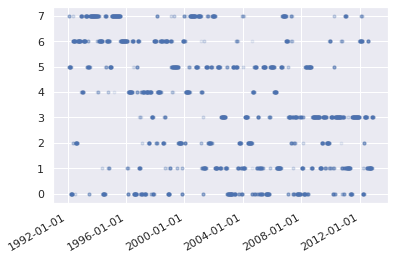

In [72]:
LabelNaive = KMTrue.predict(CorrMatrices)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaive, ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()

In [73]:
Indexshift = np.zeros(((max(LabelNaive)+1),2)).astype("int") # keep track of which cluster is assigned which number

Indexshift = pd.DataFrame({"Old Label":[],
                          "New Label":[]})
NewLabel = int(0)
for i in range(len(LabelNaive)):
    if (LabelNaive[i] in set(Indexshift["Old Label"]))==False:
        Indexshift = Indexshift.append(pd.DataFrame({"Old Label":[LabelNaive[i]],
                                                      "New Label":[NewLabel]}), ignore_index=True)
        NewLabel = int(NewLabel+1)
print(Indexshift)

   Old Label  New Label
0        7.0        0.0
1        5.0        1.0
2        0.0        2.0
3        2.0        3.0
4        6.0        4.0
5        4.0        5.0
6        1.0        6.0
7        3.0        7.0


In [74]:
LabelNaiveOrdered = np.empty(len(LabelNaive))

for i in range(len(LabelNaive)):
    LabelNaiveOrdered[i] = int(Indexshift.loc[Indexshift["Old Label"]==LabelNaive[i]]["New Label"])

CentroidsNaive = np.zeros((max(LabelNaive)+1, CorrMatrices.shape[1]))

for j in range(max(LabelNaive)+1): # go through the new orering of the clusters
    Old_Order = int(Indexshift.loc[Indexshift["New Label"]==j]["Old Label"])
    CentroidsNaive[j] = KMTrue.cluster_centers_[Old_Order]

[]

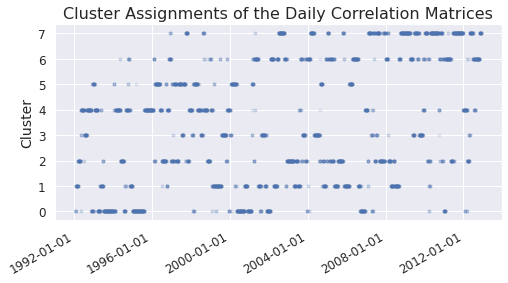

In [75]:
sns.set()
fig = plt.gcf()
fig.set_size_inches(8,4)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(T,LabelNaiveOrdered,
         ".", alpha = 0.1)
#plt.vlines(datetime.date(2001,9,11), "110", "000")
plt.gcf().autofmt_xdate()
plt.ylabel("Cluster", fontsize=14)
plt.title("Cluster Assignments of the Daily Correlation Matrices", fontsize=16)
#plt.xlabel("Time", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("ClustersVsTime.pdf", dpi=300)
plt.plot()

In [76]:
Indexshift["Old Label"][0]

7.0

In [77]:
for i in range(CentroidsNaive.shape[0]):
    print(sum(KMTrue.cluster_centers_[int(Indexshift["Old Label"][i])]  != CentroidsNaive[i]  ))
#print(KMTrue.cluster_centers_[6])

0
0
0
0
0
0
0
0


In [78]:
print(DF.columns)
# E: Energy, M: Materials, F: Financials, CS: Consumer Staples, CD: Consumer Discretionary,
# U: Utilities, T: Telecommunication, IT: Information Technology, I: Industrials, HC: Health Care

Names = ["E", "M", "F", "CS", "CD", "U", "T", "IT", "I", "HC"]

Index(['Energy', 'Materials', 'Financials', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Telecommunications Services',
       'Information Technology', 'Industrials', 'Health Care'],
      dtype='object')


In [79]:
CorrMatrices.shape
np.save("CorrMatricesTriangular", CorrMatrices)

np.save("LabelNaiveOrdered",
       LabelNaiveOrdered)
np.save("Names", Names)

## Neuralising kmeans

In [80]:
def layer1(x, centroids, i):
    # takes one instance x, centroid-matrix and index of ith centroid
    # returns values for the distances to centroid i
    mu_c = centroids[i]
    w = 2*(mu_c - centroids)
    b = (centroids**2.).sum(1) - (mu_c**2.).sum()
    h = w.dot(x) + b
    return(h)

def layer2(h,i):
    # i is the index of the cluster which we "test" here
    Indices = np.arange(len(h))
    return(min(h[Indices!=i]) )


def DecisionLayer(Minimum):
    return(Minimum > 0)



def NN_k(x,centroids,k):
    # checks if x belongs to kth cluster
    return(layer2(layer1(x,centroids,k),k))

In [81]:
# Do this for the naive kmeans

nKM = max(LabelNaive) + 1 
print(nKM)


# CHeck for all instances
Layer_Pred2 = np.empty(CorrMatrices.shape[0])

Counter = 0
for i in range(len(Layer_Pred2)): # check all instances
    Counter = 0
    for j in range(nKM): # check all possible clusters
        Decision = DecisionLayer(NN_k(CorrMatrices[i,:],KMTrue.cluster_centers_, j))    
        if Decision:
            Layer_Pred2[i] = range(nKM)[j]
            
            Counter +=1
            
        if Counter > 1:
            print("Problem", i, LabelNaive[i], Layer_Pred2[i])
print("Should be zero:", sum(Layer_Pred2 != LabelNaive))
# So this actually works!!!

8
Should be zero: 0


### LRP Functions

In [82]:
def beta(X, i, DecisionL, NN, Centroids):
    # Takes the Data X, a particular class i, a Decision Layer DecisionL and Neuralised kmeans NN = NN(x,centroids,k)
    # Returns the beta-scaling factor from eq. (3)
    IS_i = np.empty(X.shape[0])
    
    for j in range(X.shape[0]):
        IS_i[j] = NN(X[j,:],
                     Centroids,
                     i)
    return( np.mean(IS_i)**(-1.))
    

In [83]:


def Eq2(X, Centroids, c, beta):
    # take one Data.point X, the cluster Centroids and the cluster of interest c, scaling factor beta
    # output: R_k - array as in equation (2)
    
    n_C = Centroids.shape[0]
    
    H_k = layer1(X, Centroids, c)
    F_c = layer2(H_k, c)
    
    # numerator of eq. (2)
    r_k_func = np.exp(-beta * H_k) * F_c
    
    R_k_out = r_k_func / sum(r_k_func[np.arange(n_C) != c])
    #print(range(n_C), range(n_C) != c)
    return(R_k_out)

In [84]:
def Eq4(X, Centroids, c, beta):

    n_C = Centroids.shape[0]
    Index = (np.arange(n_C) != c) # index of "all clusters except c"
    
    R_previous = Eq2(X, Centroids, c, beta) # from Equation (2)
    R_previous_reduced = R_previous[Index]
    MU_c = Centroids[c]
    M_k = 0.5*(Centroids + MU_c)
    DIFF_x_m = X - M_k
    
    DIFF_x_m_reduced = DIFF_x_m[Index]
    
    W = 2*(MU_c - Centroids)
    W_reduced = W[Index]
    
    Prod = np.multiply(DIFF_x_m_reduced, W_reduced)
    
    R_InputLayer = np.zeros(len(X)) # relevance of each input-feature
    
    for i in range(len(R_InputLayer)):
        for k in range(n_C-1):
            R_InputLayer[i] += Prod[k,i] * R_previous_reduced[k] / np.sum(Prod[k,:])
    
    return(R_InputLayer)

In [85]:

def xai_clust(X, Centroids, X_Label, Dat, DecisionL, Neuralised):

    return(Eq4(X, Centroids,  X_Label,
           beta(Dat, X_Label, DecisionL, Neuralised, Centroids)))


In [86]:
xai_clust(CorrMatrices[0,:], 
          CentroidsNaive, 0, CorrMatrices, 
          DecisionLayer, NN_k).round(1)

array([ 0. ,  0.1,  0. , -0. ,  0. , -0. ,  0.1,  0. ,  0. ,  0. ,  0.1,
        0.1,  0.1,  0. ,  0. , -0. ,  0.1, -0. ,  0. ,  0. ,  0. , -0. ,
        0.1,  0. , -0.1,  0. ,  0. , -0. ,  0.1, -0. , -0. , -0.1, -0. ,
       -0. , -0.1,  0. ,  0. ,  0.1, -0. ,  0. ,  0.1, -0. ,  0.1,  0.1,
        0.1])

## Go through entire Data

In [87]:
XAI = np.zeros(CorrMatrices.shape)
LabelNaiveOrdered # is the ordered label output

for i in range(CorrMatrices.shape[0]):
    x = CorrMatrices[i,:]
    XAI[i,:] = xai_clust(x, CentroidsNaive, 
                         LabelNaiveOrdered.astype("int")[i],
                         CorrMatrices, DecisionLayer, NN_k)
print(XAI.round(1))


[[0.  0.1 0.  ... 0.1 0.1 0.1]
 [0.  0.  0.  ... 0.1 0.1 0.1]
 [0.  0.  0.  ... 0.1 0.1 0.1]
 ...
 [0.  0.1 0.1 ... 0.  0.  0. ]
 [0.  0.1 0.1 ... 0.  0.1 0. ]
 [0.  0.1 0.1 ... 0.  0.  0. ]]


In [88]:
np.save("XAI_Finance",XAI)

Cluster 0 with centroid [ 0.15 -0.05  0.06  0.15  0.13 -0.03  0.04  0.08  0.06  0.2   0.11  0.34
  0.1  -0.02  0.2   0.41  0.13  0.22  0.38  0.35  0.2   0.18  0.41  0.24
  0.32  0.22  0.22 -0.02  0.13  0.35  0.17  0.15  0.39  0.54  0.27  0.24
 -0.03  0.16  0.11  0.    0.13  0.1   0.38  0.16  0.14]
And mean importances [0.02 0.03 0.02 0.01 0.01 0.01 0.03 0.03 0.02 0.02 0.03 0.02 0.02 0.03
 0.03 0.02 0.02 0.02 0.01 0.01 0.01 0.03 0.02 0.02 0.02 0.02 0.01 0.04
 0.05 0.02 0.02 0.02 0.02 0.01 0.02 0.02 0.03 0.02 0.02 0.03 0.02 0.02
 0.02 0.03 0.04]


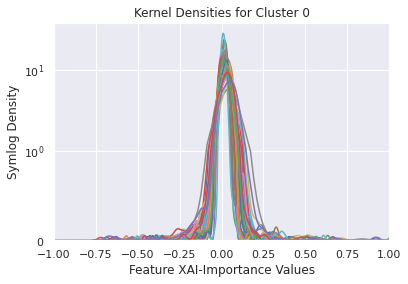

Cluster 1 with centroid [ 0.16 -0.12 -0.16 -0.02  0.29 -0.05 -0.05 -0.03 -0.07  0.35  0.3   0.45
  0.16  0.32  0.4   0.57  0.28  0.45  0.59  0.08  0.38  0.44  0.64  0.41
  0.6   0.09  0.39  0.43  0.57  0.51  0.09  0.42  0.64  0.73  0.51  0.09
  0.03  0.1   0.04  0.37  0.47  0.31  0.59  0.42  0.48]
And mean importances [0.03 0.06 0.05 0.04 0.01 0.02 0.05 0.06 0.04 0.02 0.01 0.02 0.02 0.02
 0.02 0.01 0.02 0.01 0.01 0.04 0.01 0.02 0.01 0.01 0.   0.03 0.01 0.02
 0.01 0.   0.03 0.01 0.01 0.   0.01 0.03 0.03 0.03 0.04 0.02 0.02 0.02
 0.01 0.01 0.01]


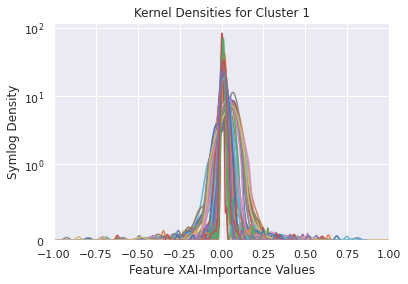

Cluster 2 with centroid [0.3  0.13 0.1  0.18 0.21 0.12 0.14 0.22 0.15 0.65 0.6  0.71 0.51 0.52
 0.61 0.78 0.59 0.7  0.72 0.52 0.59 0.63 0.78 0.65 0.7  0.54 0.55 0.6
 0.75 0.68 0.5  0.54 0.71 0.82 0.67 0.49 0.52 0.58 0.52 0.49 0.6  0.51
 0.72 0.64 0.7 ]
And mean importances [0.01 0.02 0.03 0.02 0.02 0.01 0.02 0.03 0.02 0.02 0.02 0.01 0.03 0.04
 0.02 0.01 0.02 0.02 0.01 0.01 0.03 0.03 0.01 0.01 0.01 0.02 0.02 0.05
 0.03 0.01 0.02 0.03 0.02 0.   0.01 0.02 0.05 0.03 0.02 0.03 0.03 0.03
 0.02 0.03 0.03]


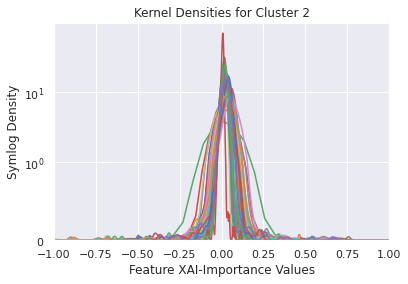

Cluster 3 with centroid [ 0.45  0.33  0.32  0.4   0.39 -0.15  0.39  0.44  0.32  0.61  0.56  0.73
  0.53 -0.05  0.6   0.76  0.57  0.6   0.75  0.48  0.06  0.65  0.73  0.63
  0.61  0.51  0.03  0.45  0.65  0.67  0.55  0.02  0.7   0.83  0.63 -0.03
  0.43  0.58  0.49 -0.04  0.06 -0.    0.74  0.55  0.68]
And mean importances [0.02 0.02 0.02 0.02 0.01 0.03 0.02 0.02 0.01 0.01 0.02 0.01 0.03 0.04
 0.02 0.01 0.02 0.01 0.01 0.01 0.04 0.04 0.01 0.01 0.01 0.02 0.04 0.03
 0.02 0.01 0.03 0.04 0.02 0.   0.01 0.06 0.03 0.02 0.02 0.05 0.04 0.03
 0.02 0.02 0.02]


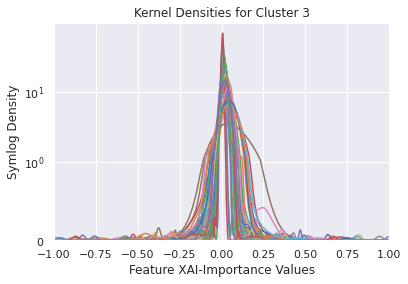

Cluster 4 with centroid [ 0.33  0.26  0.25  0.39  0.08  0.08  0.31  0.38  0.31  0.43  0.32  0.53
 -0.01 -0.03  0.43  0.64  0.44  0.43  0.48  0.13  0.13  0.33  0.57  0.45
  0.59  0.27  0.22  0.32  0.54  0.51  0.05 -0.02  0.54  0.76  0.68  0.48
 -0.01  0.07  0.04 -0.02  0.02 -0.01  0.51  0.53  0.63]
And mean importances [0.02 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.04 0.03
 0.02 0.01 0.01 0.01 0.02 0.03 0.03 0.03 0.01 0.01 0.01 0.02 0.01 0.02
 0.01 0.01 0.04 0.05 0.01 0.   0.02 0.02 0.04 0.04 0.04 0.03 0.04 0.05
 0.01 0.02 0.02]


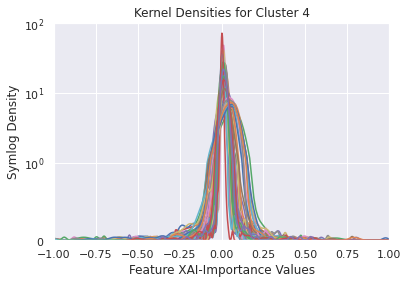

Cluster 5 with centroid [ 0.15  0.04  0.    0.1   0.07 -0.02  0.16  0.12  0.12  0.35  0.36  0.49
  0.34  0.21  0.11  0.45  0.34  0.7   0.63  0.58  0.48 -0.02  0.69  0.67
  0.64  0.57  0.45 -0.05  0.68  0.58  0.47  0.41  0.2   0.75  0.63  0.48
 -0.07  0.51  0.44  0.09  0.41  0.33  0.24  0.1   0.63]
And mean importances [0.03 0.03 0.03 0.02 0.02 0.02 0.02 0.03 0.02 0.03 0.01 0.01 0.01 0.02
 0.06 0.03 0.02 0.02 0.01 0.01 0.02 0.07 0.   0.01 0.01 0.02 0.02 0.06
 0.01 0.   0.02 0.01 0.04 0.   0.01 0.01 0.04 0.02 0.02 0.03 0.02 0.02
 0.04 0.03 0.01]


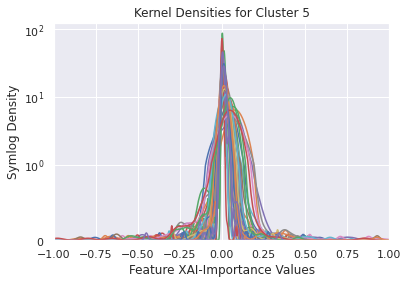

Cluster 6 with centroid [0.64 0.4  0.18 0.43 0.29 0.31 0.46 0.55 0.25 0.56 0.39 0.62 0.34 0.45
 0.61 0.77 0.32 0.42 0.59 0.38 0.51 0.52 0.64 0.42 0.45 0.33 0.36 0.27
 0.42 0.4  0.36 0.49 0.63 0.73 0.41 0.41 0.33 0.38 0.42 0.46 0.48 0.38
 0.7  0.42 0.39]
And mean importances [0.05 0.04 0.02 0.03 0.01 0.03 0.04 0.05 0.01 0.02 0.02 0.01 0.03 0.05
 0.03 0.02 0.01 0.01 0.01 0.02 0.02 0.03 0.01 0.01 0.01 0.02 0.02 0.03
 0.02 0.01 0.02 0.03 0.02 0.   0.01 0.02 0.04 0.03 0.03 0.04 0.03 0.03
 0.02 0.02 0.01]


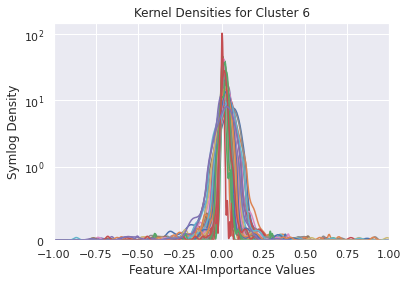

Cluster 7 with centroid [0.74 0.69 0.59 0.68 0.61 0.5  0.69 0.73 0.61 0.81 0.66 0.83 0.66 0.61
 0.81 0.89 0.73 0.67 0.81 0.67 0.63 0.77 0.85 0.73 0.69 0.67 0.62 0.63
 0.7  0.73 0.66 0.59 0.81 0.87 0.72 0.63 0.64 0.67 0.66 0.58 0.62 0.62
 0.84 0.71 0.77]
And mean importances [0.03 0.06 0.04 0.03 0.03 0.03 0.05 0.04 0.03 0.02 0.01 0.01 0.02 0.03
 0.03 0.01 0.02 0.   0.01 0.02 0.01 0.03 0.01 0.01 0.   0.02 0.02 0.03
 0.01 0.01 0.02 0.02 0.01 0.   0.01 0.02 0.04 0.02 0.03 0.03 0.02 0.03
 0.02 0.02 0.02]


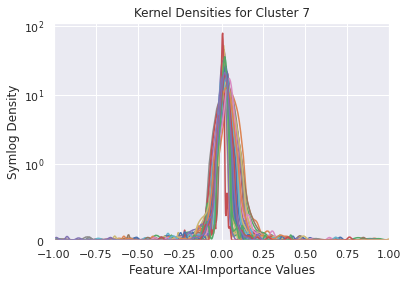

In [89]:
import warnings
warnings.filterwarnings("ignore")

for i in range(nKM):
    print("Cluster", i, "with centroid", CentroidsNaive[i].round(2))
    print("And mean importances", XAI[LabelNaiveOrdered==i,:].mean(0).round(2))
    plt.yscale("symlog", linthresh=1)

    for j in range(min(CorrMatrices.shape[1],100)):
        sns.kdeplot(XAI[LabelNaiveOrdered==i,j], label="Feature " +str(j))
    plt.xlim([-1, 1])
    plt.title("Kernel Densities for Cluster "+str(i))
    plt.ylabel("Symlog Density")
    plt.xlabel("Feature XAI-Importance Values")
    #plt.legend()
    plt.show()

In [90]:
for i in range(nKM):
    print(max(XAI[LabelNaiveOrdered==i,:].mean(0)))

0.04572860771156557
0.06255325011972519
0.05261826241841331
0.061064163179727654
0.04907393677555096
0.06883845186750386
0.046560299663955876
0.056813079833674895


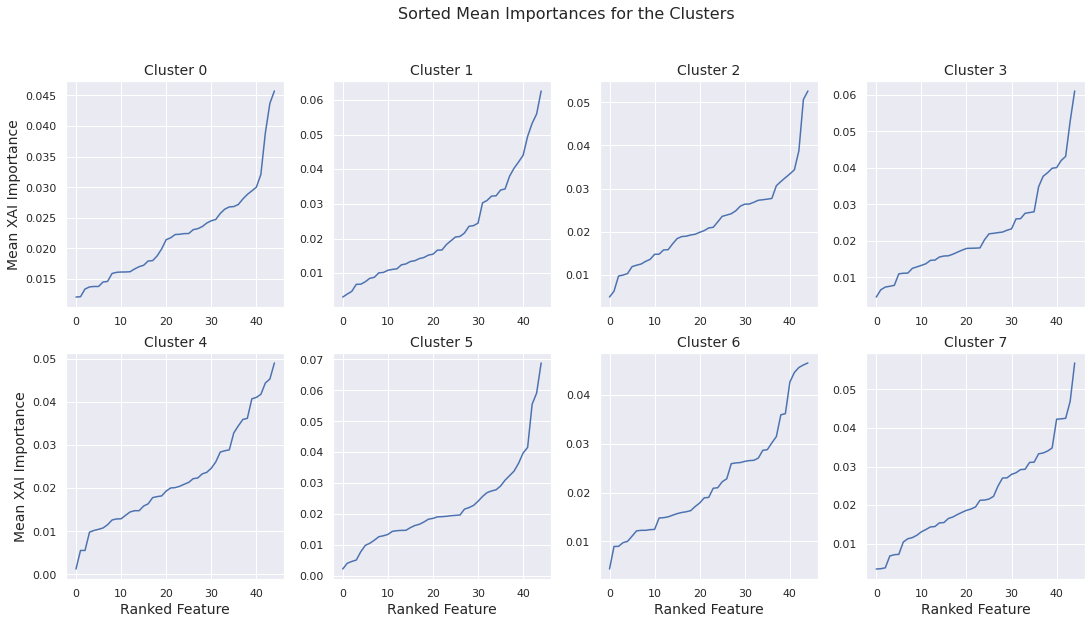

In [91]:
fig, axs = plt.subplots(2, 4,figsize=(15,8))
fig.suptitle("Sorted Mean Importances for the Clusters", fontsize = 16,y=1.05)
fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

axs[0,0].set_ylabel("Mean XAI Importance", fontsize=14)
axs[1,0].set_ylabel("Mean XAI Importance", fontsize=14)

for i in range(4):
    axs[0,i].set_title("Cluster "+ str(i), fontsize=14)
    axs[0,i].plot(np.sort(XAI[LabelNaiveOrdered==i,:].mean(0)))
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)

for i in range(4):
    axs[1,i].set_title("Cluster "+ str(i+4), fontsize=14)
    axs[1,i].set_xlabel('Ranked Feature', fontsize=14)
    axs[1,i].plot(np.sort(XAI[LabelNaiveOrdered==i+4,:].mean(0)))
plt.show()    

At least for some clusters, one can clearly see an elbow-curve-behaviour at the left and/or right extremes of the feature ranking.

## Now aggregated across all clusters

Text(0.5, 0, 'Sorted Features')

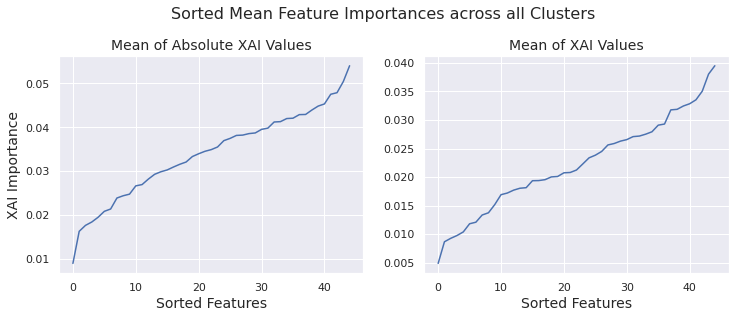

In [92]:
f, ax = plt.subplots( 1,2,figsize=(12,4))
f.suptitle("Sorted Mean Feature Importances across all Clusters", fontsize = 16,y=1.05)

ax[0].set_ylabel("XAI Importance", fontsize=14)

ax[0].set_title("Mean of Absolute XAI Values", fontsize=14)
ax[0].plot(np.sort(abs(XAI).mean(0)))
ax[0].set_xlabel("Sorted Features", fontsize=14)

ax[1].set_title("Mean of XAI Values", fontsize=14)
ax[1].plot(np.sort(XAI.mean(0)))
ax[1].set_xlabel("Sorted Features", fontsize=14)


These are some interesting plots and also show elbow curves for the means. The means of absolute values are less clear to interpret as a sigmoid/elbos

## Export some Plots

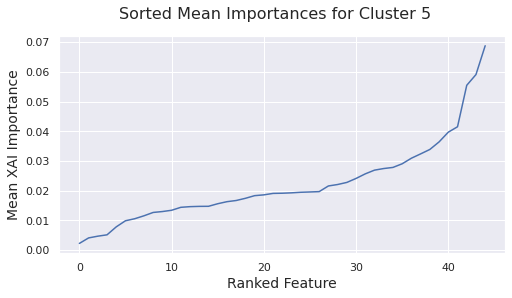

In [93]:
j = 5

fig, axs = plt.subplots(1, 1,figsize=(8,4))
fig.suptitle("Sorted Mean Importances for Cluster "+str(j), fontsize = 16)
#fig.tight_layout()
#fig.subplots_adjust(hspace=0.2)

#axs,set_title("Sorted Mean Importances for Cluster 2")
axs.set_ylabel("Mean XAI Importance", fontsize=14)
axs.plot(np.sort(XAI[LabelNaiveOrdered==j,:].mean(0)))
axs.set_xlabel('Ranked Feature', fontsize=14)
fig.savefig("XAI_Cluster"+str(j)+".png",  dpi=800)

In [94]:
# Export the corresponding data
np.save("XAI_Data_Cluster5.npy",
        XAI[LabelNaiveOrdered==j,:].mean(0))

## Detecting the Elbow

Use a linear interpolation before the elbow or at the centre of the curve. Then, assume that the elbow is at the consecutively n last ranked instances for which the XAI-value is above 3*sigma + linear regression.

In [95]:

def DetectElbow(Data, lower, upper, Deviation = 3, plot = False):
    # Input: Data and a lower/upper index for the range to use for linear interpolation
    # output: The index I for which all Data[-i:-1] are clearly above the linear regression
    #         i.e. the elbow starts at Data[-i]
    #         and all Features which are deemed relevant
    
    Index = np.argsort(Data)
    Sorted = np.sort(Data)
    LR = linregress(np.arange(lower, upper),
                   Sorted[lower:upper])
    
    residua = Sorted - (LR.intercept + LR.slope * np.arange(len(Data)))
    
    Output = None
    RelevantIndex = None
    if residua[-1] > Deviation* LR.stderr:
        Check = True
        i = 1
        while Check:
            i+=1
            Check = (residua[len(residua)-i] > Deviation*LR.stderr)
        Output = i
        RelevantIndex = Index[len(Index)-i+1:] # last i Index values, i,e. highest values
    
    if plot:
            plt.plot(Sorted)
            plt.plot(LR.intercept + LR.slope * np.arange(len(Data)))
            plt.axvline(len(residua)-i,
                       c="red")
            plt.show()
    
    return([Output-1, RelevantIndex])

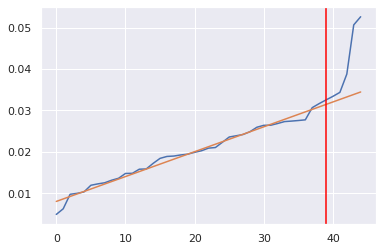

[5, array([39, 40, 13, 27, 36])]

In [98]:
DetectElbow(XAI[LabelNaiveOrdered==2,:].mean(0), 0, 40, 100, True)

In [99]:
AllRelevant = np.array([])

for j in range(nKM):
    DE = DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 40, 100, False)
    print(j, DE)
    AllRelevant=np.concatenate([AllRelevant,DE[1]])
print(AllRelevant)

0 [5, array([14,  1, 44, 27, 28])]
1 [8, array([19, 38,  8,  3,  2,  6,  7,  1])]
2 [5, array([39, 40, 13, 27, 36])]
3 [9, array([36, 21, 13, 20, 31, 40, 26, 39, 35])]
4 [6, array([38, 12, 40, 36, 41, 31])]
5 [7, array([43, 42, 32, 36, 27, 14, 21])]
6 [7, array([36,  6,  1, 39, 13,  7,  0])]
7 [5, array([36,  7,  2,  6,  1])]
[14.  1. 44. 27. 28. 19. 38.  8.  3.  2.  6.  7.  1. 39. 40. 13. 27. 36.
 36. 21. 13. 20. 31. 40. 26. 39. 35. 38. 12. 40. 36. 41. 31. 43. 42. 32.
 36. 27. 14. 21. 36.  6.  1. 39. 13.  7.  0. 36.  7.  2.  6.  1.]


In [100]:
np.array(np.unique(AllRelevant, return_counts=True)).T

array([[ 0.,  1.],
       [ 1.,  4.],
       [ 2.,  2.],
       [ 3.,  1.],
       [ 6.,  3.],
       [ 7.,  3.],
       [ 8.,  1.],
       [12.,  1.],
       [13.,  3.],
       [14.,  2.],
       [19.,  1.],
       [20.,  1.],
       [21.,  2.],
       [26.,  1.],
       [27.,  3.],
       [28.,  1.],
       [31.,  2.],
       [32.,  1.],
       [35.,  1.],
       [36.,  6.],
       [38.,  2.],
       [39.,  3.],
       [40.,  3.],
       [41.,  1.],
       [42.,  1.],
       [43.,  1.],
       [44.,  1.]])

(array([1., 4., 2., 1., 0., 0., 3., 3., 1., 0., 0., 0., 1., 3., 2., 0., 0.,
        0., 0., 1., 1., 2., 0., 0., 0., 0., 1., 3., 1., 0., 0., 2., 1., 0.,
        0., 1., 6., 0., 2., 3., 3., 1., 1., 1.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5,
        32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5,
        43.5]),
 <BarContainer object of 44 artists>)

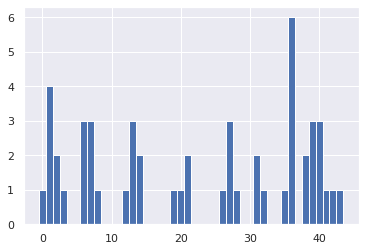

In [101]:
plt.hist(AllRelevant, bins = np.arange(-0.5,
                                       max(AllRelevant)+0.5,1))

### Transform back to original sectors

In [102]:
def ReverseDiag(Array, ZERO = False):
    N = np.sqrt(2*len(Array)+0.25)+0.5
    N = int(N)
    Original = np.ones(int(N**2.)).reshape(1,-1)
    
    if ZERO:
        Original = np.zeros(int(N**2.)).reshape(1,-1)
    
    index = np.triu(np.ones((N,N)),1)
    index = index.reshape(1,-1)
    index = index.astype(bool)
    
    Original[index] = Array # upper triangle
    Original = Original.reshape((N,N))
    Original = Original.T  # guarantee symmetry
    Original=Original.reshape(1,-1)
    Original[index] = Array
    Original=Original.reshape((N,N))

    return(Original)

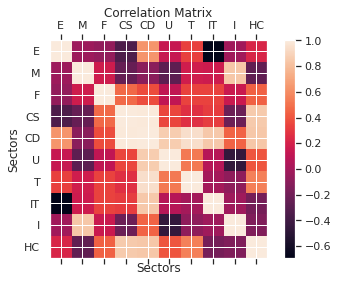

In [103]:
def plot_matrix(m, title='Correlation Matrix', cmap=plt.cm.Blues, labels=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(m)
    plt.title(title,y=1.08)
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.xlabel('Sectors')
    plt.ylabel('Sectors')
    plt.show()
    
plot_matrix(ReverseDiag(CorrMatrices[1,:]),
           labels = Names)

### Plot Relevances

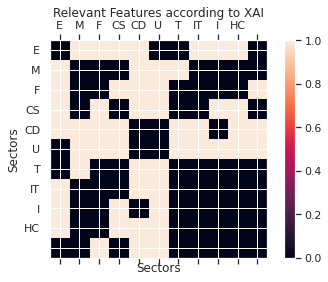

In [104]:
RelevantCombined = np.array(list(set(AllRelevant))).astype("int")
RelevancePlot = np.zeros(55)
RelevancePlot[RelevantCombined] = 1.
plot_matrix(ReverseDiag(RelevancePlot,
                       ZERO = True),
            title = "Relevant Features according to XAI",
           labels = Names)

In [115]:
def PrintNames(Mat, Names):
    Out = list()
    for i in range(Mat.shape[0]):
        for j in range(i+1, Mat.shape[1]):
            print(i,j)
            if Mat[i,j]==1:
                Out.append(Names[i]+"/"+Names[j])
    return(Out)

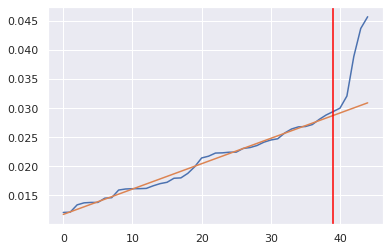

0 5 [14  1 44 27 28]


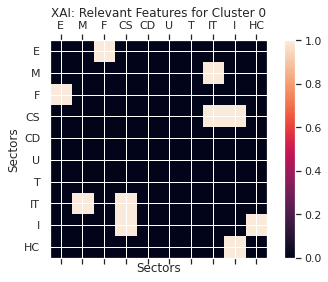

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Relevant Correlations: ['E/F', 'M/IT', 'CS/IT', 'CS/I', 'I/HC']
 # # # # 


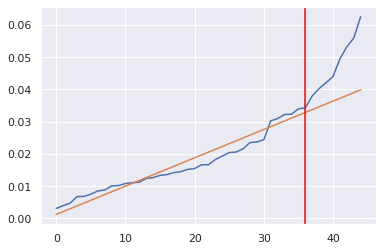

1 8 [19 38  8  3  2  6  7  1]


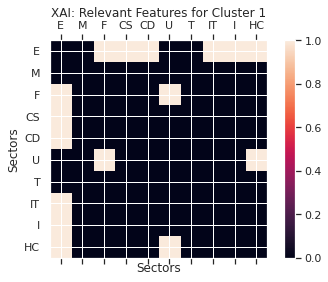

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Relevant Correlations: ['E/F', 'E/CS', 'E/CD', 'E/IT', 'E/I', 'E/HC', 'F/U', 'U/HC']
 # # # # 


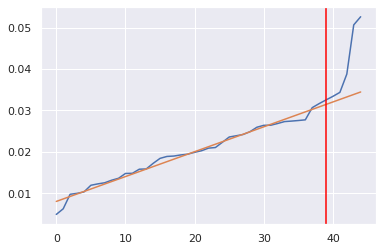

2 5 [39 40 13 27 36]


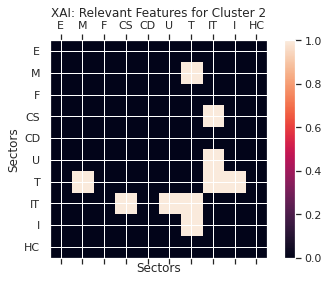

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Relevant Correlations: ['M/T', 'CS/IT', 'U/IT', 'T/IT', 'T/I']
 # # # # 


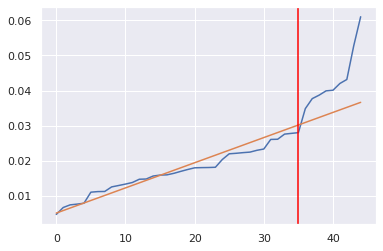

3 9 [36 21 13 20 31 40 26 39 35]


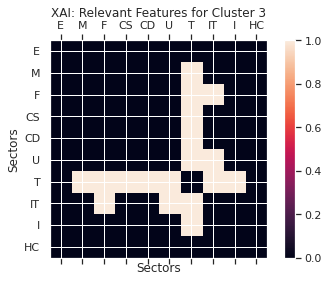

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Relevant Correlations: ['M/T', 'F/T', 'F/IT', 'CS/T', 'CD/T', 'U/T', 'U/IT', 'T/IT', 'T/I']
 # # # # 


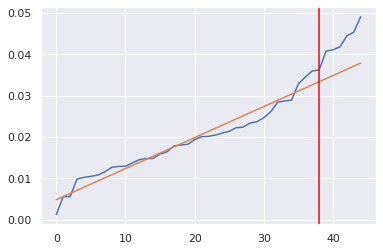

4 6 [38 12 40 36 41 31]


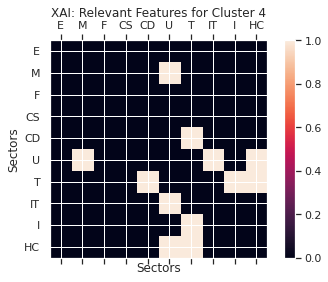

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Relevant Correlations: ['M/U', 'CD/T', 'U/IT', 'U/HC', 'T/I', 'T/HC']
 # # # # 


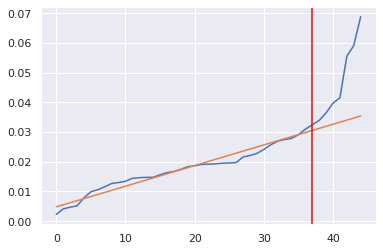

5 7 [43 42 32 36 27 14 21]


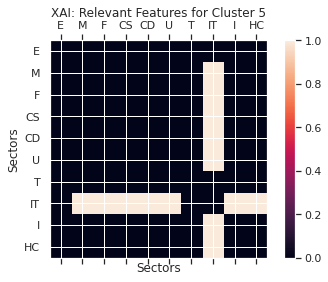

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Relevant Correlations: ['M/IT', 'F/IT', 'CS/IT', 'CD/IT', 'U/IT', 'IT/I', 'IT/HC']
 # # # # 


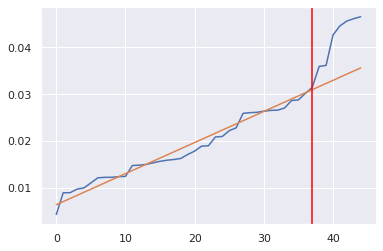

6 7 [36  6  1 39 13  7  0]


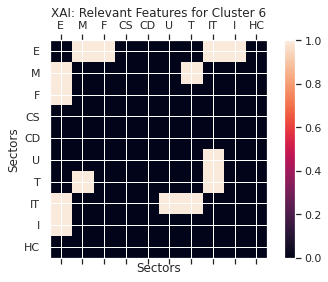

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Relevant Correlations: ['E/M', 'E/F', 'E/IT', 'E/I', 'M/T', 'U/IT', 'T/IT']
 # # # # 


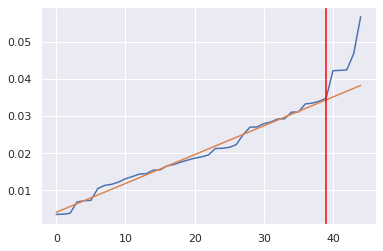

7 5 [36  7  2  6  1]


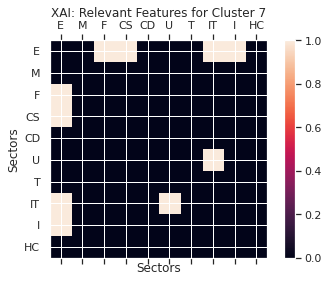

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
Relevant Correlations: ['E/F', 'E/CS', 'E/IT', 'E/I', 'U/IT']
 # # # # 


In [114]:
# and plots for each Cluster
for j in range(nKM):
    #DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 50, 100, True)
    DE = DetectElbow(XAI[LabelNaiveOrdered==j,:].mean(0), 0, 40, 100, True)
    print(j, DE[0], DE[1] )
    
    relIndex = np.zeros(45)
    relIndex[DE[1]] = 1.
    RelMat = ReverseDiag(relIndex,
                       ZERO = True)
    plot_matrix(RelMat,
            title = "XAI: Relevant Features for Cluster "+str(j),
           labels = Names)
    print("Relevant Correlations:",PrintNames(RelMat, Names))
    
    print(" # # # # ")

In [116]:
np.save("XAI_Finance",XAI)